# Forecasting strategies

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/208-forecasting_strategies.ipynb)

There are 5 possible forecasting strategies:

* **Recursive**: sequentially forecasts `step` points and use them to forecast next points.
* **Direct**: uses separate model to forecast each time subsegment
* **DirRec**: uses a separate model to forecast each time subsegment, fitting the next model on the train set extended with the forecasts of previous models
* **MIMO**: uses a single multi-output model
* **DIRMO**: MIMO + DirREC


The first two of these strategies are available in ETNA, and we will take a closer look at them in this notebook.

**Table of contents**

* [Loading dataset](#chapter1)
* [Recursive strategy](#chapter2)
* [Direct strategy](#chapter3)
    * [Pipeline](#section_3_1)
    * [DirectEnsemble](#section_3_2)
* [Summary](#chapter4)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

from etna.analysis import plot_backtest
from etna.datasets import TSDataset
from etna.metrics import MAE
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.models import CatBoostPerSegmentModel
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform

In [3]:
HORIZON = 14
HISTORY_LEN = 5 * HORIZON
NUMBER_OF_LAGS = 21

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

Let's load and plot the dataset:

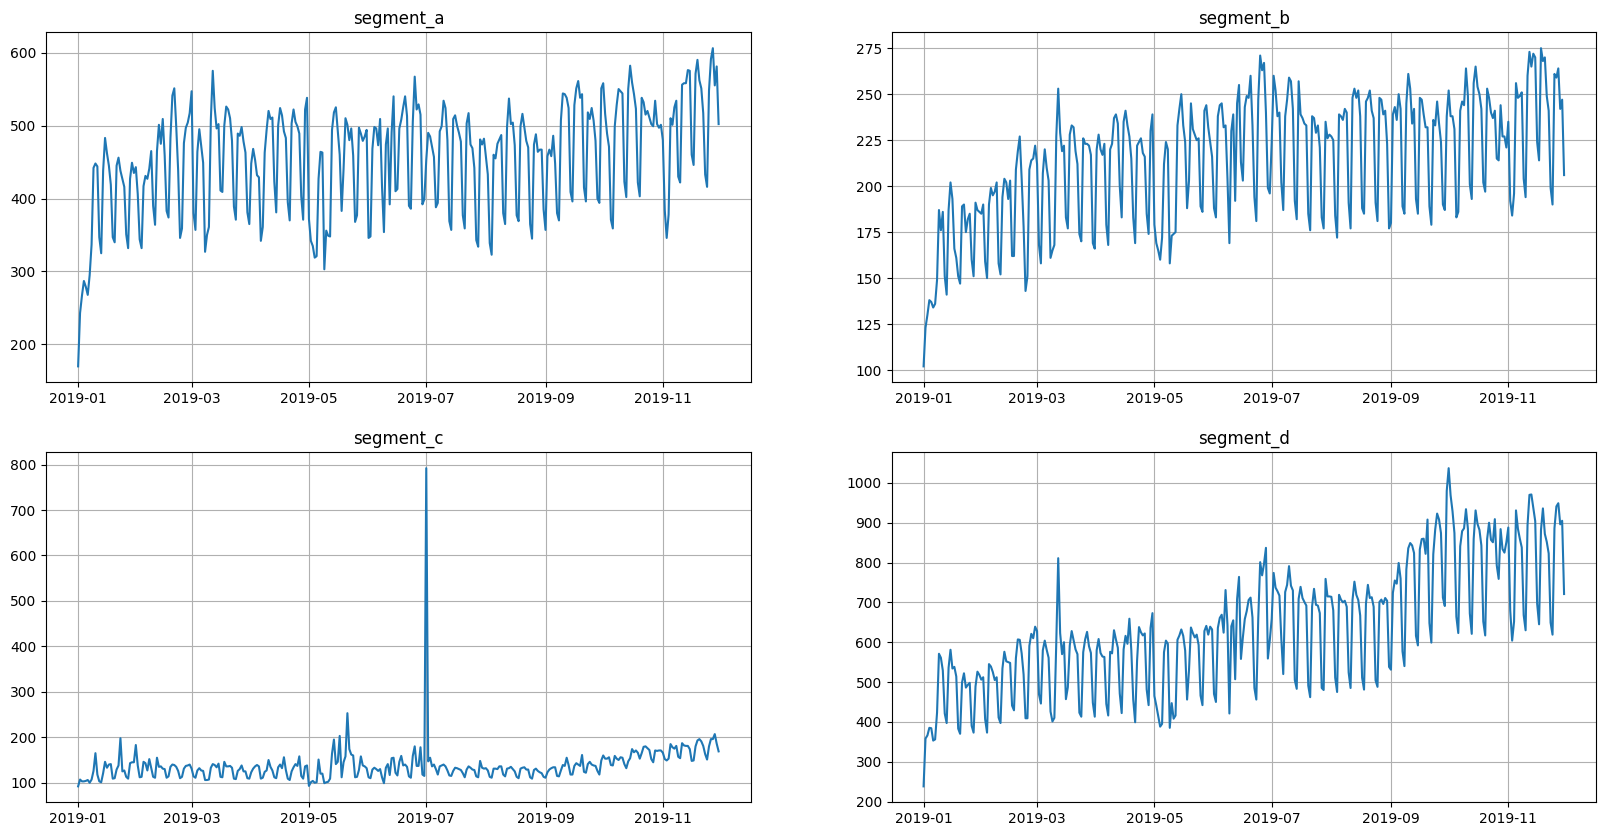

In [4]:
df = pd.read_csv("data/example_dataset.csv")
ts = TSDataset(df, freq="D")

ts.plot()

## 2. Recursive strategy <a class="anchor" id="chapter2"></a>

Recursive strategy in ETNA is implemented via `AutoregressivePipeline`.

`AutoRegressivePipeline` is pipeline, which iteratively forecasts `step` values ahead and after that uses forecasted values to build the features for the next steps. 

* Could work slowly in case of small `step`, since the method needs to recalculate features $\lceil{\frac{horizon}{step}} \rceil$ times
* Allows to use lags, that are lower than `HORIZON`
* Could be imprecise on forecasting with large horizons. The thing is that we accumulate errors of forecasts for further horizons. 
* Stable for noise-free time series

**Note**:

We will add linear trend into the model(because we are working with tree-based models) and use target's lags as features

In [5]:
from etna.pipeline import AutoRegressivePipeline

In [6]:
model = CatBoostPerSegmentModel()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=[i for i in range(1, 1 + NUMBER_OF_LAGS)], out_column="target_lag"),
]

autoregressivepipeline = AutoRegressivePipeline(model=model, transforms=transforms, horizon=HORIZON, step=1)
recursive_backtest_result = autoregressivepipeline.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

metrics_recursive_df = recursive_backtest_result["metrics"]
list_recursive_forecast_ts = recursive_backtest_result["forecasts"]

autoregressive_pipeline_metrics = metrics_recursive_df[["SMAPE", "MAE", "MAPE", "fold_number"]].mean()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   15.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   15.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [7]:
metrics_recursive_df

,segment,SMAPE,MAE,MAPE,fold_number
0,segment_a,4.175293,19.979242,4.256666,0
0,segment_a,9.837298,48.380469,9.289885,1
0,segment_a,6.852662,33.502961,6.743145,2
0,segment_a,6.663534,30.994614,7.277259,3
0,segment_a,5.759203,30.567373,5.616410,4
1,segment_b,4.113736,9.205893,4.226268,0
1,segment_b,3.685315,8.672262,3.608048,1
1,segment_b,5.732703,13.160143,5.850097,2
1,segment_b,7.153258,16.906464,7.248034,3
1,segment_b,3.973106,9.265952,4.047496,4


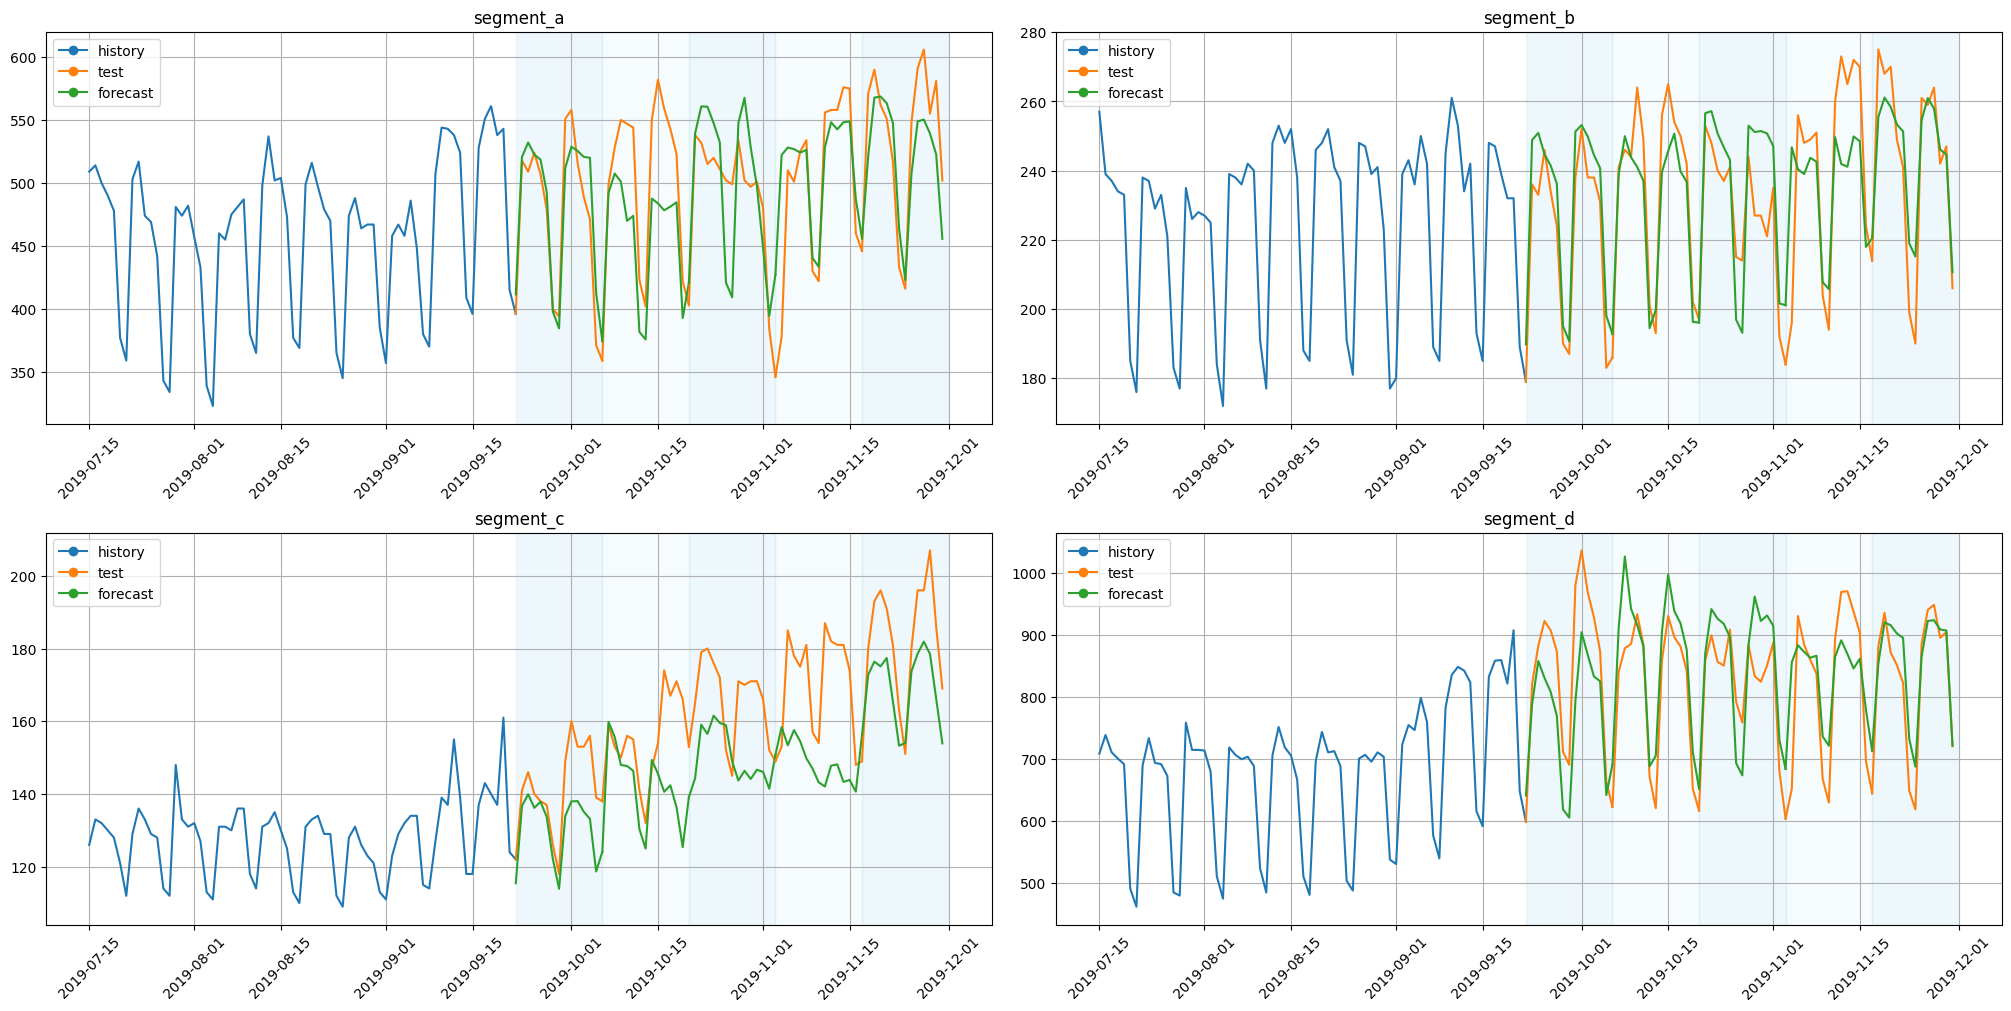

In [8]:
plot_backtest(list_recursive_forecast_ts, ts, history_len=HISTORY_LEN)

## 3. Direct Strategy <a class="anchor" id="chapter3"></a>

Recursive strategy in ETNA is implemented via `Pipeline` and `DirectEnsemble`. This strategy assumes conditional independence of forecasts.

### 3.1 `Pipeline` <a class="anchor" id="section_3_1"></a>

`Pipeline` implements the version of direct strategy, where the only one model is fitted to forecast all the points in the future. This implies the several things:

* `Pipeline` doesn't accept lags less than `horizon`
* This is the most time-efficient method: both in training and in forecasting
* This method might lose the quality with the growth of horizon when using the lags, as the only horizon-far lags are available for all the points

**Note:**

As mentioned above, we cannot use lags less than `horizon`, so now we will use lags from `horizon` to `horizon + number_of_lags`

In [9]:
from etna.pipeline import Pipeline

In [10]:
model = CatBoostPerSegmentModel()
transforms = [
    LinearTrendTransform(in_column="target"),
    LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + NUMBER_OF_LAGS)), out_column="target_lag"),
]

pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline_backtest_result = pipeline.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

metrics_pipeline_df = pipeline_backtest_result["metrics"]
list_pipeline_forecast_ts = pipeline_backtest_result["forecasts"]

pipeline_metrics = metrics_pipeline_df[["SMAPE", "MAE", "MAPE", "fold_number"]].mean()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   14.9s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   14.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

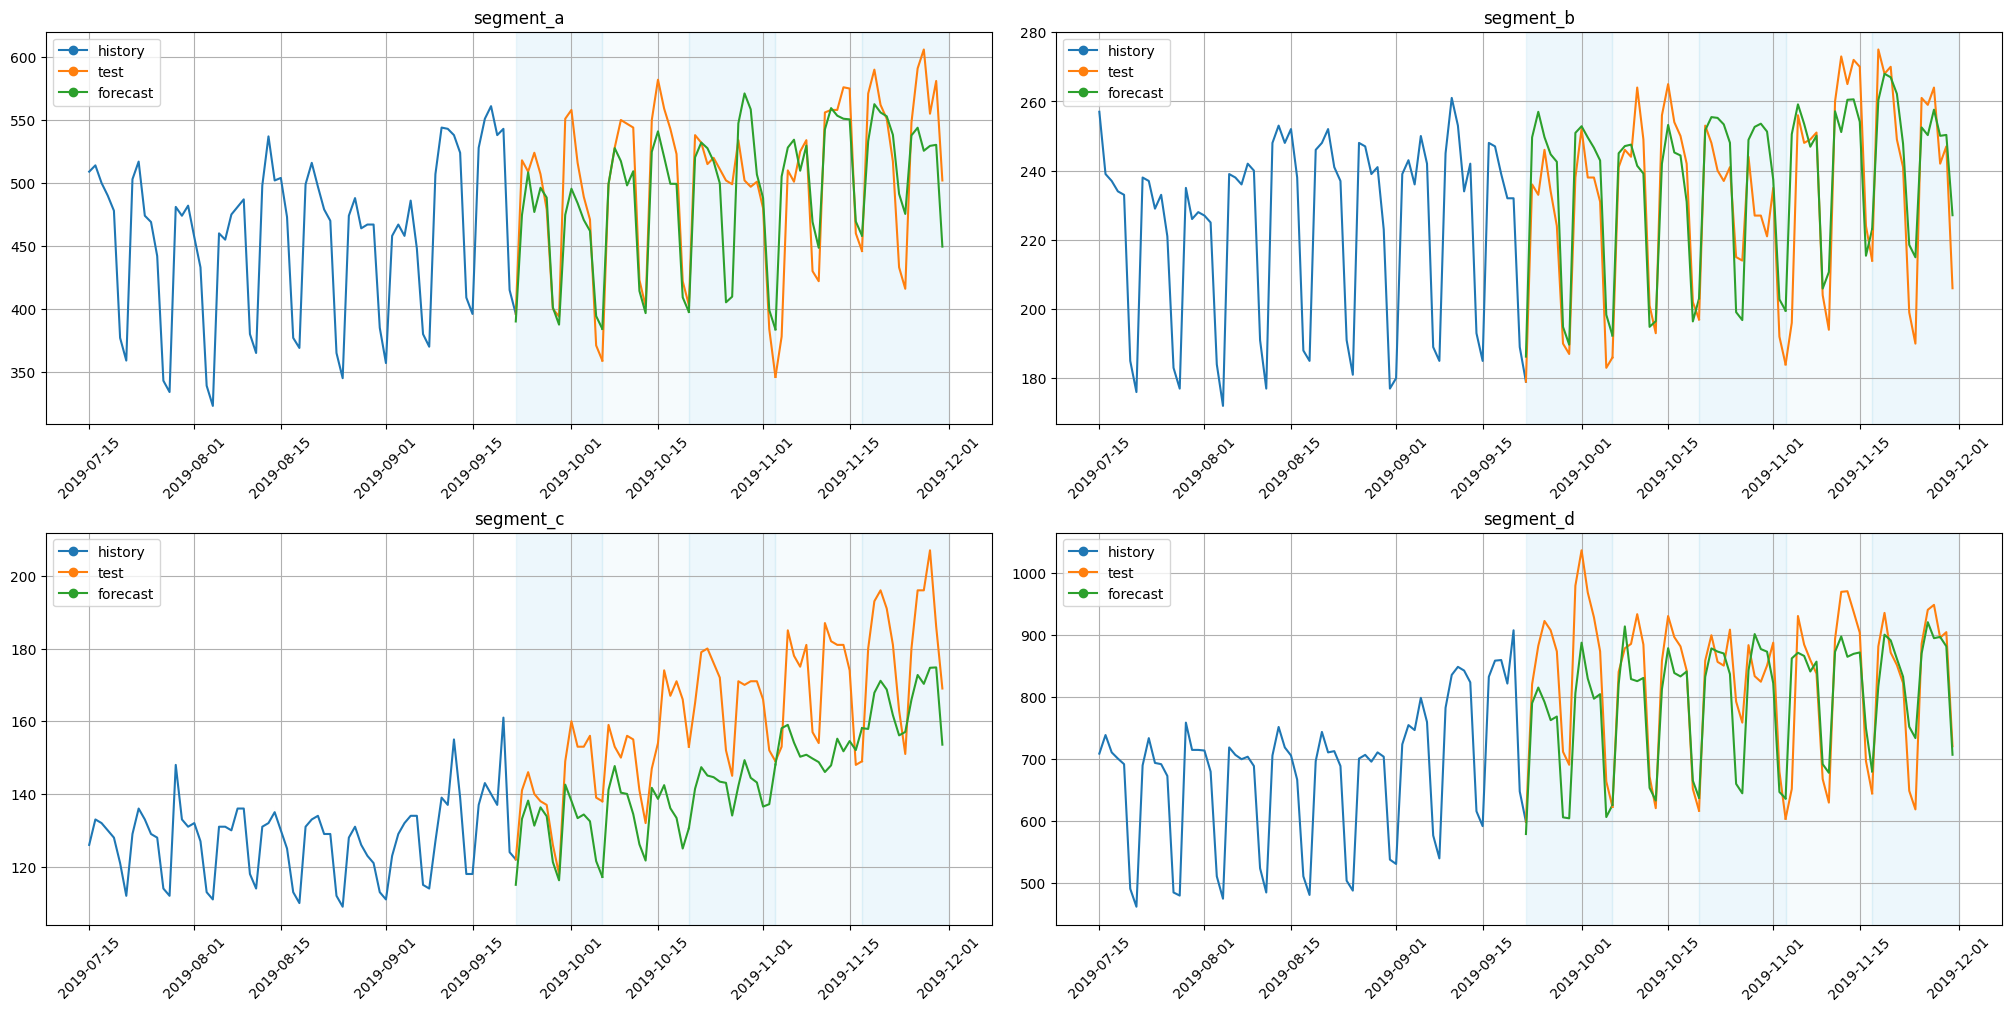

In [11]:
plot_backtest(list_pipeline_forecast_ts, ts, history_len=HISTORY_LEN)

### 3.2 `DirectEnsemble` <a class="anchor" id="section_3_2"></a>

`DirectEnsemble` fits the separate pipeline to forecast each time subsegment. Forecasting the future, it selects base pipeline with the shortest horizon that covers the timestamp of the current forecasted point. Let's see an example of choosing a base pipeline for forecasting:

![title](./assets/forecasting_strategies/ensemle.png)

* This method can be useful when we have different pipelines, that are effective on different horizons.
* The computational time growth with the number of base pipelines.
* The forecasts from this strategy might look like a "broken curve", this happens because they are obtained from the independent models

#### Example
Let's build the separate pipeline for each week of interest. The first week will be forecasted using the lags from `7` to `7 + number_of_lags` and the second one with lags from `horizon` to `horizon + number_of_lags`. We expect that the using of the near lags for the first week might improve the forecast quality

First, let's build our pipelines:

In [12]:
horizons = [7, 14]

model_1 = CatBoostPerSegmentModel()
transforms_1 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target", lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)], out_column="target_lag"
    ),
]
pipeline_1 = Pipeline(model=model_1, transforms=transforms_1, horizon=horizons[0])


model_2 = CatBoostPerSegmentModel()
transforms_2 = [
    LinearTrendTransform(in_column="target"),
    LagTransform(
        in_column="target", lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)], out_column="target_lag"
    ),
]

pipeline_2 = Pipeline(model=model_2, transforms=transforms_2, horizon=horizons[1])

Secondly, we will create ensemble and forecasts:

In [13]:
from etna.ensembles import DirectEnsemble

In [14]:
ensemble = DirectEnsemble(pipelines=[pipeline_1, pipeline_2])

ensemble_backtest_result = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])

metrics_ensemble_df = ensemble_backtest_result["metrics"]
list_ensemble_forecast_ts = ensemble_backtest_result["forecasts"]

ensemble_metrics = metrics_ensemble_df[["SMAPE", "MAE", "MAPE", "fold_number"]].mean()

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   13.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   19.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   25.8s
[Parallel(n_jobs=1)]: Do

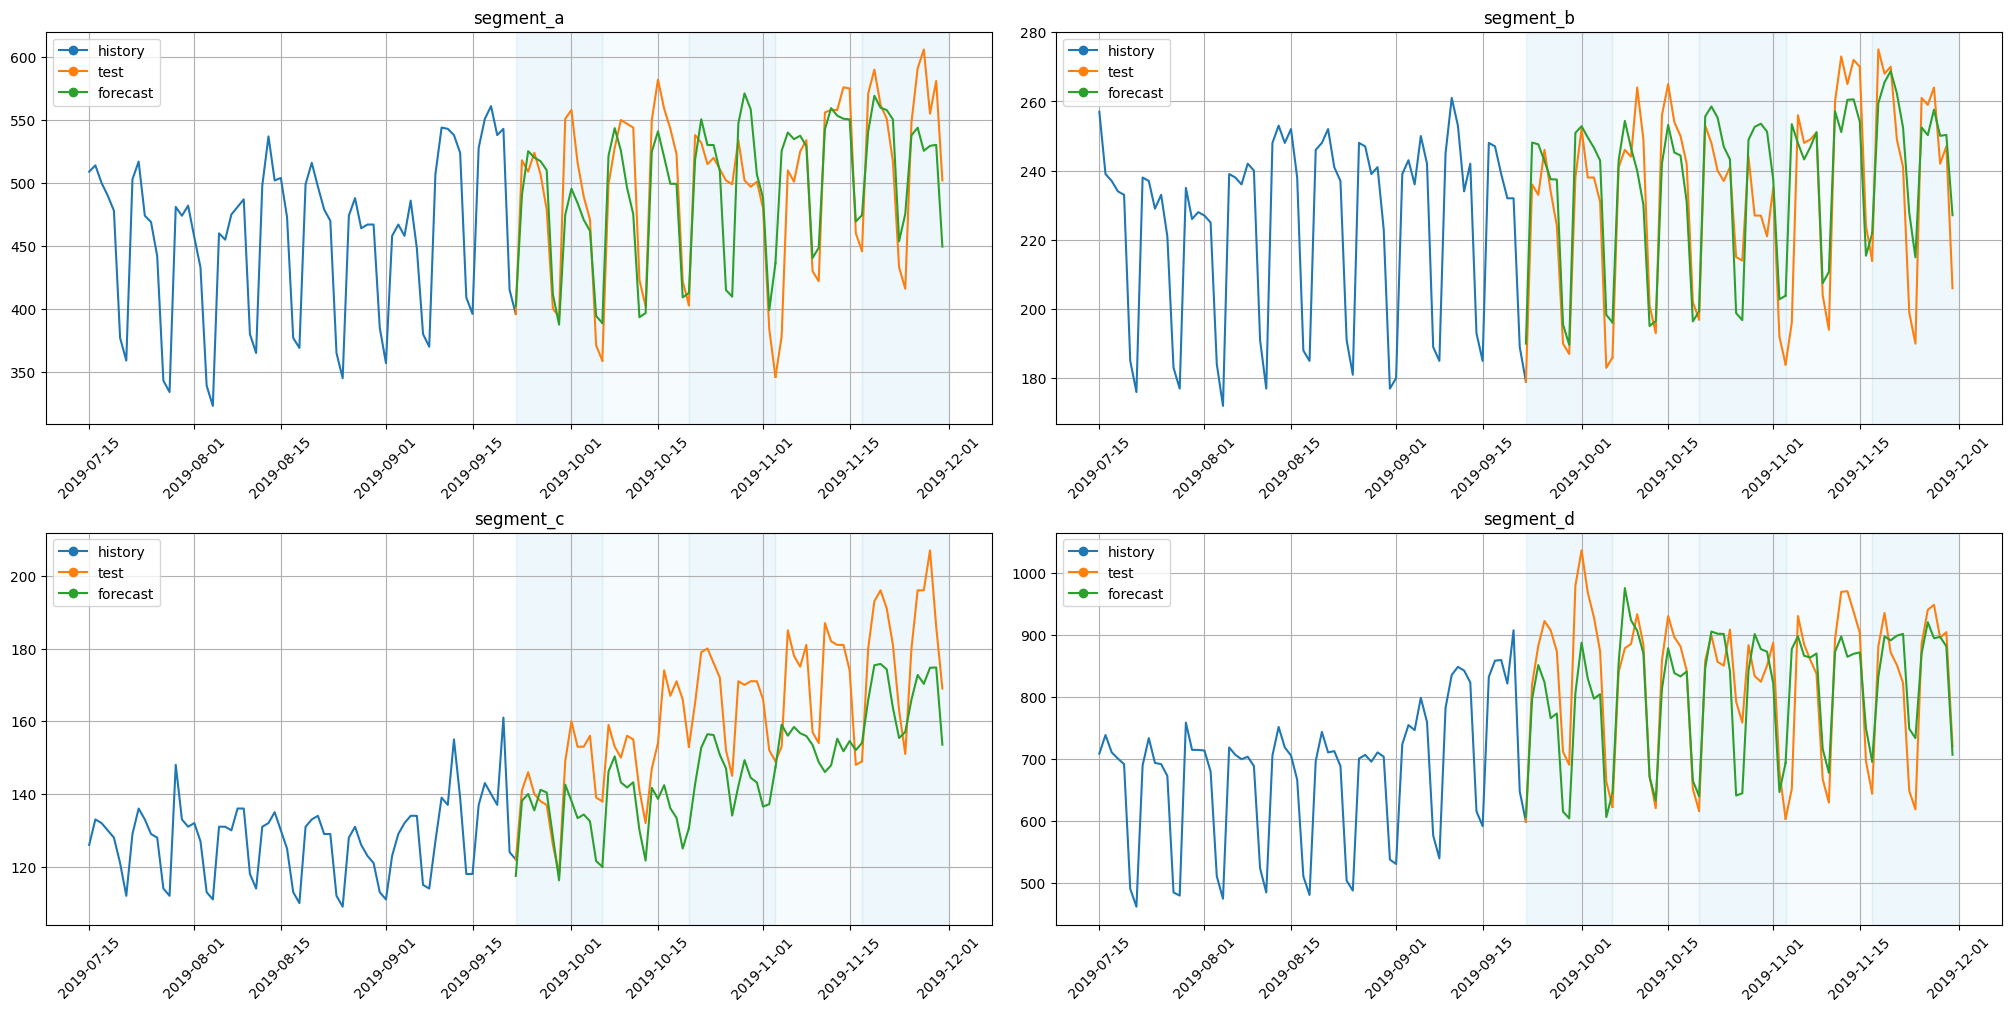

In [15]:
plot_backtest(list_ensemble_forecast_ts, ts, history_len=HISTORY_LEN)

`DirectEnsemble` described above requires the building of the separate pipeline for each of the time subsegment. This pipelines often has many common parts and differs only in the few places. To make the definition of the pipelines a little bit shorter, you can use `assemble_pipelines`. It generates the pipelines using the following rules:

1. Input models(horizons) can be specified as one model(horizon) or as a sequence of models(horizons). In first case all generated pipelines will have input model(horizon) and in the second case `i`-th pipeline will hold `i`-th model(horizon). 
2. Transforms can be specified as a sequence of transform or as a sequence of sequences of transforms. Let's look at some examples to understand better transformations with transforms:

Let's consider that `A`, `B`, `C`, `D`, `E` are different transforms.

**Example 1**

If input transform sequence is `[A, B, C]`, function will put `[A, B, C]` for each pipeline

**Example 2**

If input transform sequence is `[A, [B, C], D, E]`, function will put `[A, B, D, E]` for the first generated pipeline and `[A, C, D, E]` for the second.

**Example 3**

If input transform sequence is `[A, [B, C], [D, E]]`, function will put `[A, B, D]` for the first generated pipeline and `[A, C, E]` for the second.

**Example 4**

If input transform sequence is `[A, [B, None]]`, function will put `[A, B]` for the first generated pipeline and `[A]` for the second.


Let's build the ensemble from the previous section using `assemble_pipelines`

In [16]:
from etna.pipeline import assemble_pipelines

In [17]:
models = [CatBoostPerSegmentModel(), CatBoostPerSegmentModel()]
transforms = [
    LinearTrendTransform(in_column="target"),
    [
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[0], horizons[0] + NUMBER_OF_LAGS)],
            out_column="target_lag",
        ),
        LagTransform(
            in_column="target",
            lags=[i for i in range(horizons[1], horizons[1] + NUMBER_OF_LAGS)],
            out_column="target_lag",
        ),
    ],
]

pipelines = assemble_pipelines(models=models, transforms=transforms, horizons=horizons)
pipelines

[Pipeline(model = CatBoostPerSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], out_column = 'target_lag', )], horizon = 7, ),
 Pipeline(model = CatBoostPerSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LinearTrendTransform(in_column = 'target', poly_degree = 1, ), LagTransform(in_column = 'target', lags = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], out_column = 'target_lag', )], horizon = 14, )]

Pipelines generation process looks now a bit simpler, isn't it? Now it's time to create `DirectEnsemble` out of them:

In [18]:
ensemble = DirectEnsemble(pipelines=pipelines)

metrics_ensemble_df_2 = ensemble.backtest(ts=ts, metrics=[SMAPE(), MAE(), MAPE()])["metrics"]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   17.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   24.7s
[Parallel(n_jobs=1)]: Do

Let's check that the forecasts has not changed:

In [19]:
pd.testing.assert_frame_equal(metrics_ensemble_df_2, metrics_ensemble_df)

## 4. Summary <a class="anchor" id="chapter4"></a>

In this notebook, we discussed forecasting strategies available in ETNA and look at the examples of their usage. In conclusion, let's compare their quality on the considered dataset:

In [20]:
df_res = pd.DataFrame(
    data=[ensemble_metrics, pipeline_metrics, autoregressive_pipeline_metrics],
    index=["direct_ensemble", "pipeline", "autoregressive_pipeline"],
).drop("fold_number", axis=1)
df_res = df_res.sort_values(by="SMAPE")
df_res

,SMAPE,MAE,MAPE
direct_ensemble,7.152913,28.657613,7.004382
autoregressive_pipeline,7.247425,29.945816,7.117746
pipeline,7.319264,28.476013,7.102676
